In [1]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")


import gensim
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec

import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn import utils
from sklearn.model_selection import train_test_split

Importing Data

In [2]:
playstore = pd.read_csv('D:/Project/NPL_PlayStoreReview/reviews.csv')
playstore.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,I cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaN,newest,com.anydo
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,I have been begging for a refund from this app...,1,0,NaN,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,newest,com.anydo
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,https://play-lh.googleusercontent.com/a-/AOh14...,Very costly for the premium version (approx In...,1,0,NaN,2020-10-27 08:18:40,NaN,NaN,newest,com.anydo
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,SKGflorida@bellsouth.net DAVID S,https://play-lh.googleusercontent.com/-75aK0WF...,"Used to keep me organized, but all the 2020 UP...",1,0,NaN,2020-10-26 13:28:07,What do you find troublesome about the update?...,2020-10-26 14:58:29,newest,com.anydo
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,Louann Stoker,https://play-lh.googleusercontent.com/-pBcY_Z-...,Dan Birthday Oct 28,1,0,5.6.0.7,2020-10-26 06:10:50,NaN,NaN,newest,com.anydo


In [3]:
# Drop the unnecessary columns
playstore = playstore[['content', 'score']]
playstore.head()

,content,score
0,I cannot open the app anymore,1
1,I have been begging for a refund from this app...,1
2,Very costly for the premium version (approx In...,1
3,"Used to keep me organized, but all the 2020 UP...",1
4,Dan Birthday Oct 28,1


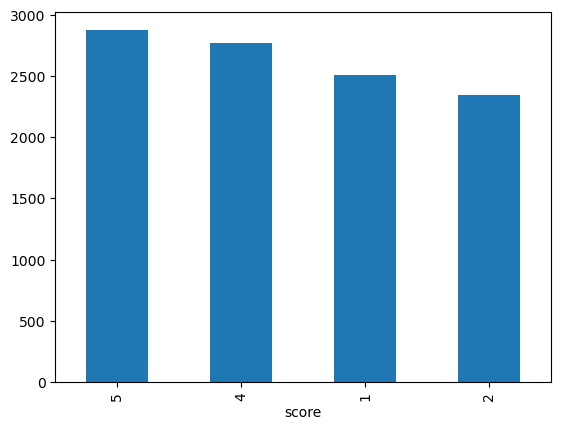

In [4]:
#Let's assume that the score 1-2 is negative reviews (0), the score 3 is neutral and the score 4-5 is positive reviews (1).
#Drop the rows with the score 3.
playstore.drop(playstore[playstore['score'] == 3].index, inplace = True)
playstore['score'].value_counts().plot(kind = 'bar');

In [5]:
#Classify the score class.
def score_class(score):
  score = int(score)
  if score <= 2:
    return 0
  elif score >= 4:
    return 1

In [6]:
playstore['score'] = playstore.score.apply(score_class)

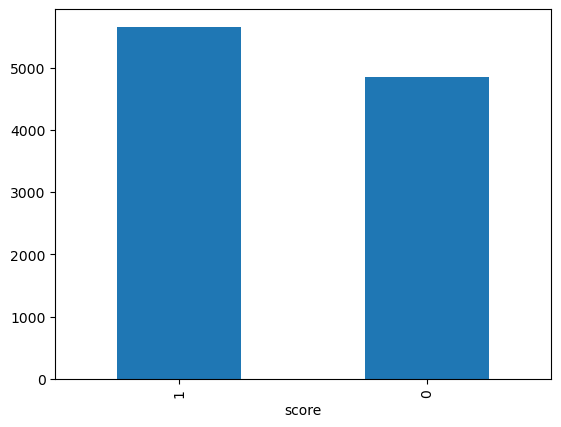

In [7]:
playstore['score'].value_counts().plot(kind = 'bar');

Text Cleaning

In [8]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text

playstore['content'] = playstore['content'].apply(cleanText)
playstore.head(5)

C:\Users\User\AppData\Local\Temp\ipykernel_7420\3540516488.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text


,content,score
0,i cannot open the app anymore,0
1,i have been begging for a refund from this app...,0
2,very costly for the premium version (appro ind...,0
3,"used to keep me organized, but all the 2020 up...",0
4,dan birthday oct 28,0


In [9]:
# Split the train-test data.
#Tokenize the words
import nltk
#from nltk.corpus import stopwords
nltk.download('punkt')

train, test = train_test_split(playstore, test_size=0.2, random_state=42) #80/20

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

train_tagged = train.apply(lambda r: TaggedDocument(words=tokenize_text(r['content']), tags=[r.score]), axis=1)
test_tagged = test.apply(lambda r: TaggedDocument(words=tokenize_text(r['content']), tags=[r.score]), axis=1)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


Bag-of-Words (BOW)

In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression

content = playstore['content'].values
y = playstore['score'].values
content_train, content_test, yy_train, yy_test = train_test_split(content,y, test_size=0.2, random_state=42)

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

BOW = CountVectorizer()
BOW.fit(content_train)

CountVectorizer()

In [12]:
XX_train = BOW.transform(content_train)
XX_test  = BOW.transform(content_test)

In [13]:
#Naive Bayes BOW
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.naive_bayes import MultinomialNB
cNB = MultinomialNB()
cNB.fit(XX_train, yy_train)
y_predict_NB = cNB.predict(XX_test)

print('Testing accuracy NB BOW %s' % accuracy_score(yy_test, y_predict_NB))
print('Testing F1 score NB BOW: {}'.format(f1_score(yy_test, y_predict_NB, average = 'macro')))
print('Testing Precision score NB BOW: {}'.format(precision_score(yy_test, y_predict_NB, average = 'macro')))
print('Testing Recall score NB BOW: {}'.format(recall_score(yy_test, y_predict_NB, average = 'macro')))

Testing accuracy NB BOW 0.8557829604950024
Testing F1 score NB BOW: 0.8552286959660028
Testing Precision score NB BOW: 0.8548737938178051
Testing Recall score NB BOW: 0.8557562508539418


In [14]:
#SVM BOW
clf = svm.SVC(gamma='scale')
clf.fit(XX_train, yy_train) 
y_predict_SVM = clf.predict(XX_test)

print('Testing accuracy SVM BOW %s' % accuracy_score(yy_test, y_predict_SVM))
print('Testing F1 score SVM BOW: {}'.format(f1_score(yy_test, y_predict_SVM, average = 'macro')))
print('Testing Precision score SVM BOW: {}'.format(precision_score(yy_test, y_predict_SVM, average = 'macro')))
print('Testing Recall score SVM BOW: {}'.format(recall_score(yy_test, y_predict_SVM, average = 'macro')))

Testing accuracy SVM BOW 0.8605425987624941
Testing F1 score SVM BOW: 0.8601731229061789
Testing Precision score SVM BOW: 0.8597752005906608
Testing Recall score SVM BOW: 0.861297080657649


In [15]:
#Logistic Regression (LR) BOW
logreg = LogisticRegression(n_jobs=1, C=1e5,solver='lbfgs', max_iter=1000)
logreg.fit(XX_train, yy_train)
y_predict_LR = logreg.predict(XX_test)

print('Testing accuracy SVM BOW %s' % accuracy_score(yy_test, y_predict_LR))
print('Testing F1 score SVM BOW: {}'.format(f1_score(yy_test, y_predict_LR, average = 'macro')))
print('Testing Precision score SVM BOW: {}'.format(precision_score(yy_test, y_predict_LR, average = 'macro')))
print('Testing Recall score SVM BOW: {}'.format(recall_score(yy_test, y_predict_LR, average = 'macro')))

Testing accuracy SVM BOW 0.7943836268443598
Testing F1 score SVM BOW: 0.7931992380813503
Testing Precision score SVM BOW: 0.7933808630120247
Testing Recall score SVM BOW: 0.7930409436626134


c:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


TF-IDF

In [16]:
#split-data-train-test
content = playstore['content'].values
y = playstore['score'].values
content_train, content_test, yyy_train, yyy_test = train_test_split(content,y, test_size=0.2, random_state=42)

from sklearn.feature_extraction.text import TfidfVectorizer
TFIDF = TfidfVectorizer()
TFIDF.fit(content_train)

TfidfVectorizer()

In [17]:
XXX_train = TFIDF.transform(content_train)
XXX_test  = TFIDF.transform(content_test)

In [18]:
#Naive Bayes TF-IDF
cNB = MultinomialNB()
cNB.fit(XXX_train, yyy_train)
ytf_predict_NB = cNB.predict(XXX_test)

print('Testing accuracy NB TF-IDF %s' % accuracy_score(yy_test, ytf_predict_NB))
print('Testing F1 score NB TF-IDF: {}'.format(f1_score(yyy_test, ytf_predict_NB, average = 'macro')))
print('Testing Precision score NB TF-IDF: {}'.format(precision_score(yyy_test, ytf_predict_NB, average = 'macro')))
print('Testing Recall score NB TF-IDF: {}'.format(recall_score(yyy_test, ytf_predict_NB, average = 'macro')))

Testing accuracy NB TF-IDF 0.8586387434554974
Testing F1 score NB TF-IDF: 0.8580785425324051
Testing Precision score NB TF-IDF: 0.8577408443433864
Testing Recall score NB TF-IDF: 0.8585580908138635


In [19]:
#SVM TF-IDF
clf = svm.SVC(gamma='scale')
clf.fit(XXX_train, yyy_train) 
ytf_predict_SVM = clf.predict(XXX_test)

print('Testing accuracy SVM TF-IDF %s' % accuracy_score(yyy_test, ytf_predict_SVM))
print('Testing F1 score SVM TF-IDF: {}'.format(f1_score(yyy_test, ytf_predict_SVM, average = 'macro')))
print('Testing Precision score SVM TF-IDF: {}'.format(precision_score(yyy_test, ytf_predict_SVM, average = 'macro')))
print('Testing Recall score SVM TF-IDF: {}'.format(recall_score(yyy_test, ytf_predict_SVM, average = 'macro')))

Testing accuracy SVM TF-IDF 0.8776772965254641
Testing F1 score SVM TF-IDF: 0.8773032747864282
Testing Precision score SVM TF-IDF: 0.8768520115072919
Testing Recall score SVM TF-IDF: 0.8782456619756798


In [20]:
#Logistic Regression (LR) TF-IDF
logreg = LogisticRegression(n_jobs=1, C=1e5,solver='lbfgs', max_iter=1000)
logreg.fit(XXX_train, yyy_train)
ytf_predict_LR = logreg.predict(XXX_test)

print('Testing accuracy LR TF-IDF %s' % accuracy_score(yyy_test, ytf_predict_LR))
print('Testing F1 score LR TF-IDF: {}'.format(f1_score(yyy_test, ytf_predict_LR, average = 'macro')))
print('Testing Precision score LR TF-IDF: {}'.format(precision_score(yyy_test, ytf_predict_LR, average = 'macro')))
print('Testing Recall score LR TF-IDF: {}'.format(recall_score(yyy_test, ytf_predict_LR, average = 'macro')))

Testing accuracy LR TF-IDF 0.7858162779628748
Testing F1 score LR TF-IDF: 0.7847336065573771
Testing Precision score LR TF-IDF: 0.7846956876486594
Testing Recall score LR TF-IDF: 0.784772965341349


c:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
